In [1]:
#!pip3 -qq install torch==0.4.1
#!pip install -q --upgrade nltk gensim bokeh pandas

!wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
!unzip quora.zip

import nltk
nltk.download('punkt')

Archive:  quora.zip
  inflating: train.csv               


[nltk_data] Downloading package punkt to /home/alexander/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 

np.random.seed(42)

# Введение в PyTorch

PyTorch - это один из самых известных фреймворков для работы с нейронными сетями.

Почему именно он? Ну, он няшен, питоняч и проще в отладке - по сравнению с монстрами типа tensoflow (хотя tf 2.0 с eager execution будет примерно таким же).

И вообще, мы тут не фреймворки, а сеточки учить собирались :)



## Автоматическое дифференцирование

### Графы вычислений

Графы вычислений - это такой удобный способ быстро считать градиенты сложных-пресложных функций.

Например, функция

$$f = (x + y) \cdot z$$

представится графом

![graph](Images/Circuit.png "Graph")  
*From [Backpropagation, Intuitions - CS231n](http://cs231n.github.io/optimization-2/)*

**Задание** Зададим значения $x, y, z$ (зеленым на картинке). Как посчитать $\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}, \frac{\partial f}{\partial z}$? (*Вспоминаем, что такое backpropagation*)

В PyTorch такие вычисления делаются очень просто.

Сначала определяется функция - просто последовательность операций:

In [3]:
x = torch.tensor(-2., requires_grad=True)
y = torch.tensor(5., requires_grad=True)
z = torch.tensor(-4., requires_grad=True)

q = x + y
f = q * z

А затем говорим ей: "Посчитай градиенты, пожалуйста". И происходит магия - какая-то такая:

![graph](https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/dynamic_graph.gif)  
*From [github.com/pytorch/pytorch](https://github.com/pytorch/pytorch)*

По описанной последовательности операций *на лету* строится граф вычислений, и обратный проход выполняется по нему.

В этом ключевое отличие от tensoflow: граф не нужно компилировать до исполнения кода - это позволяет более гибко управлять его структурой.

In [4]:
f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = tensor(-4.)
df/dy = tensor(-4.)


Вызов метода `backward()` вычисляет градиенты для всех тензоров, у которых `requires_grad == True`.

Есть еще альтернативный способ не вычислять градиенты - пользоваться менеджерами контекста ([Locally disabling gradient computation](https://pytorch.org/docs/stable/autograd.html#locally-disabling-gradient-computation)):
```python
torch.autograd.no_grad()
torch.autograd.enable_grad()
torch.autograd.set_grad_enabled(mode)

```

In [5]:
with torch.autograd.no_grad():
    x = torch.tensor(-2., requires_grad=True)
    y = torch.tensor(5., requires_grad=True)
    q = x + y

z = torch.tensor(-4., requires_grad=True)
f = q * z

f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = None
df/dy = None


Подробнее о том, как работает autograd, можно почитать здесь: [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html).

В целом, любой тензор в pytorch - аналог многомерных матриц в numpy.

Он содержит данные:

In [6]:
x.data

tensor(-2.)

Накопленный градиент:

In [7]:
x.grad

Функцию, как градиент считать:

In [8]:
q.grad_fn

И всякую дополнительную метаинформацию:

In [9]:
x.type(), x.shape, x.device, x.layout

('torch.FloatTensor', torch.Size([]), device(type='cpu'), torch.strided)

Зачем... У меня один вопрос - зачем вот это вот нам нужно?

### Задача для разминки

Чтобы разобраться - решим простенькую задачу на линейную регрессию:

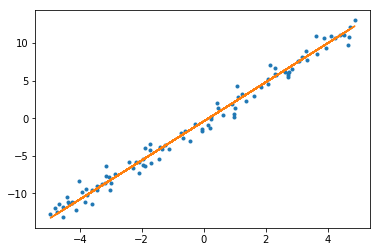

In [10]:
w_orig, b_orig = 2.6, -0.4

X = np.random.rand(100) * 10. - 5.
y_orig = w_orig * X + b_orig

y = y_orig + np.random.randn(100)

plt.plot(X, y, '.')
plt.plot(X, y_orig)
plt.show()

Хочется прикрутить сюда backpropagation, да.

Есть два параметра $w$ и $b$ - их нужно подобрать такими, чтобы они были как можно ближе к исходным $w_{orig}, b_{orig}$.

Что будем оптимизировать? Оптимизировать будем MSE:
$$J(w, b) = \frac{1}{N} \sum_{i=1}^N || \hat y_i - y_i(w, b)||^2 =\frac{1}{N} \sum_{i=1}^N || \hat y_i - (w \cdot x_i + b)||^2. $$

С такой функций потерь можем запустить простой градиентный спуск (даже не стохастический пока):
$$w_{t+1} := w_t - \alpha \cdot \frac{\partial J}{\partial w}(w_t, b_t)$$
$$b_{t+1} := w_t - \alpha \cdot \frac{\partial J}{\partial b}(w_t, b_t)$$

**Задание** Реализовать оптимизацию на чистом numpy.

Для этого нужно:
1. Посчитать значение функции на прямом проходе: $y(w, b) = w \cdot x + b$;
2. Подумать и посчитать градиенты $\frac{\partial J}{\partial w}, \frac{\partial J}{\partial b}$ на обратном проходе;
3. Сдвинуть $w, b$ по антиградиентам.

In [12]:
X.shape

(100,)

Epoch = 100, Loss = 0.029362309994758463, w = 2.5935973607180016, b = -0.5688026446280502


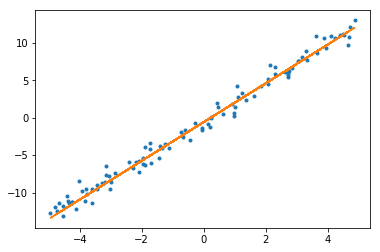

In [19]:
def display_progress(epoch, loss, w, b, X, y, y_pred):
    clear_output(True)
    print('Epoch = {}, Loss = {}, w = {}, b = {}'.format(epoch, loss, w, b))
    plt.plot(X, y, '.')
    plt.plot(X, y_pred)
    plt.show()
    time.sleep(1)


w = np.random.randn()
b = np.random.randn()

alpha = 0.01

for i in range(100):
    y_pred = w * X + b

    loss = np.power(y_orig - y_pred, 2).mean()

    w_grad = (-2*(y_orig - y_pred)*X).mean()
    b_grad = (-2*(y_orig - y_pred)).mean()

    w -= alpha * w_grad
    b -= alpha * b_grad
    
    if (i + 1) % 5 == 0:
        display_progress(i + 1, loss, w, b, X, y, y_pred)

На PyTorch то же самое сделать несколько проще - подсчет прямого прохода копируется почти дословно.

Обратный проход мы уже умеем - нужно просто вызвать `loss.backward()`.

Для обновления `w` и `b` нужно иметь в виду следующее. Во-первых, pytorch не даст просто так обновить их:

In [20]:
w = torch.randn(1, requires_grad=True)

w -= 1.

RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.

Проблема в сложности поддержки in-place операций для работы autograd ([In place operations with autograd](https://pytorch.org/docs/stable/notes/autograd.html#in-place-operations-with-autograd)).

Но нам и не нужна поддержка градиентов! Мы не будем делать backward pass через эту операцию - нужно всего лишь обновить значение переменной. Чтобы сделать это, можно воспользовать контекстом `no_grad`, либо производить обновление непосредственно буфера, который использует данный тензор:

In [21]:
w.data -= 1.

Другое, что нужно помнить - градиенты в тензорах накапливаются. Между вызовами `loss.backward()` нужно обнулять градиенты у `w` и `b`:
```python
w.grad.zero_()
b.grad.zero_()
```

**Задание** Реализовать линейную регрессию на pytorch.

In [0]:
X = torch.as_tensor(X).float()
y = torch.as_tensor(y).float()

w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

for i in range(100):
    <copy forward pass and add backward pass + parameters updates>
    
    if (i + 1) % 5 == 0:
        display_progress(i + 1, loss, w.item(), b.item(), 
                         X.data.numpy(), y.data.numpy(), y_pred.data.numpy())

Думать нужно уже гораздо меньше, да? :)

Про другие фишки низкоуровнего pytorch можно почитать здесь: [PyTorch — ваш новый фреймворк глубокого обучения](https://habr.com/post/334380/) (статья веселая, но немного устарела, читать лучше с оглядкой на [PyTorch 0.4.0 Migration Guide](https://pytorch.org/blog/pytorch-0_4_0-migration-guide/))

## Word embeddings и высокоуровневый API PyTorch

Займёмся рассмотрением высокоуровневого API - в нем уже реализованы разные классы-запчасти для обучения нейронок.

Будем решать всё ту же задачу, что и в прошлый раз - обучение словных эмбеддингов, только теперь мы будем учить их самостоятельно!

Для начала нужно подготовить данные для обучения.

Соберем и токенизируем тексты:

In [22]:
import pandas as pd
from nltk.tokenize import word_tokenize

quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())

tokenized_texts = [word_tokenize(text.lower()) for text in texts]

Соберем индекс самых частотных слов:

In [23]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break
        
    word2index[word] = len(word2index)
    
index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]
    
print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 28634
Tokens count: 6969946
Unknown tokens appeared: 123601
Most freq words: ['?', 'the', 'what', 'is', 'a', 'i', 'to', 'in', 'how', 'of', 'do', 'are', 'and', 'for', ',', 'can', 'you', 'why', 'it', 'my']


### Skip-Gram Word2vec

Начнем с skip-gram модели обучения word2vec.

Это простая модель всего из двух слоев. Ее идея - учить вектора эмбеддингов такими, чтобы по ним можно было как можно лучше предсказать контекст соответствующих слов. То есть если мы хорошо научились кодировать слова, с которыми встречается данное - значит, мы что-то знаем и о нем самом. Например, естественным образом получится, что слова, встречающиеся в одинаковых контекстах (скажем, `apple` и `orange`)  будут иметь близкие вектора эмбеддингов.

![loss](Images/Word2vecExample.jpeg "Loss")  
*From cs224n, Lecture 2*

Для этого мы моделируем вероятности $\{P(w_{c+j}|w_c):  j = c-k, ..., c+k, j \neq c\}$, где $k$ - размер контекстного окна, $c$ - индекс центрального слова.

![obj](Images/Objective.png "Objective")

Соберем такую модель: будем учить пару матриц $U$ - матрицу эмбеддингов, которую потом и возьмем для своих задач, и $V$ - матрицу выходного слоя.

Каждому слову в словаре соответствует строка в матрице $U$ и столбец $V$.

![skip-gram](Images/SkipGram.png "SkipGram")

Что тут происходит? Слово отображается в эмбеддинг - строку $u_c$. Дальше этот эмбеддинг умножается на матрицу $V$. 

В итоге получаем набор числе $v_j^T u_c$ - степень похожести слова с номером $j$ и нашего слова.

Преобразуем эти числа в что-то вроде вероятностей - воспользуемся функцией softmax: $P(i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$.

А дальше будем считать кросс-энтропийные потери:

$$-\sum_{-k \leq j \leq k, j \neq 0} \log \frac{\exp(v_{c+j}^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)} \to \min_{U, V}.$$

В итоге, вектор $u_c$ будет приближаться к векторам $v_{c_j}$ из его контекста.

Реализуем это всё, чтобы разобраться.

#### Генерация батчей

Для начала нужно собрать контексты.

In [27]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1) 
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))
            
    return contexts

In [28]:
contexts = build_contexts(tokenized_texts, window_size=2)

In [29]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

Преобразуем слова в индексы.

In [30]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context]) 
            for central_word, context in contexts]

Реализуем генератор батчей для нашей нейронки:

In [157]:
import random

def make_skip_gram_batchs_iter(contexts, window_size, num_skips, batch_size):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * window_size
    
    central_words = [word for word, context in contexts if len(context) == 2 * window_size and word != 0]
    contexts = [context for word, context in contexts if len(context) == 2 * window_size and word != 0]
    
    batch_size = int(batch_size / num_skips)
    batchs_count = int(math.ceil(len(contexts) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    while True:
        indices = np.arange(len(contexts))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
            batch_indices = indices[batch_begin: batch_end]

            batch_data, batch_labels = [], []

            for data_ind in batch_indices:
                central_word, context = central_words[data_ind], contexts[data_ind]
                
                words_to_use = random.sample(context, num_skips)
                batch_data.extend([central_word] * num_skips)
                batch_labels.extend(words_to_use)
            
            yield batch_data, batch_labels

In [193]:
batch, labels = next(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=2, batch_size=32))

Initializing batchs generator with 295262 batchs per epoch


In [199]:
len(batch)

32

In [200]:
len(labels)

32

#### nn.Sequential

Простейший способ реализовать модель на PyTorch - использовать модуль `nn.Sequential`. В нем нужно просто перечислить все слои, и он будет применять их последовательно.

In [160]:
model = nn.Sequential(
    nn.Embedding(len(word2index), 32),
    nn.Linear(32, len(word2index))
)

Еще одна особенность pytorch, о которой до сих пор не говорили - поддержка вычислений на видеокарте. На видеокарте большинство нейронок считается гораздо быстрее благодаря высокой параллелизации. Сказать pytorch'у, чтобы он считал на видеокарте, очень просто:

In [161]:
model.cuda()

Sequential(
  (0): Embedding(28634, 32)
  (1): Linear(in_features=32, out_features=28634, bias=True)
)

либо

In [162]:
device = torch.device("cuda")

model = model.to(device)

Создать тензоры на видеокарте можно, например, так:

In [163]:
batch = torch.cuda.LongTensor(batch)
labels = torch.cuda.LongTensor(labels)

Заставить модель посчитать значение можно так:

In [164]:
logits = model(batch)

Теперь нам нужна функция потерь

In [165]:
loss_function = nn.CrossEntropyLoss().cuda() 

Посчитать значение можно так:

In [166]:
loss = loss_function(logits, labels)

А теперь, конечно же, backprop!

In [167]:
loss.backward()

И, наконец, оптимизатор.

Будем использовать Adam. Интерфейс - передать список оптимизируемых параметров и learning rate.

In [168]:
optimizer = optim.Adam(model.parameters(), lr=0.01) 

Оптимизация идет просто - нужно вызвать `step()`:

In [169]:
print(model[1].weight)

optimizer.step()

print(model[1].weight)

Parameter containing:
tensor([[ 0.0196, -0.0375,  0.1588,  ..., -0.0771,  0.1564,  0.1165],
        [-0.0805,  0.1727,  0.0152,  ...,  0.1089, -0.0936, -0.0901],
        [ 0.0752,  0.0550,  0.1010,  ...,  0.1246,  0.1562, -0.0927],
        ...,
        [ 0.0023, -0.0448,  0.1571,  ..., -0.1264, -0.1630, -0.1352],
        [ 0.1286,  0.0096, -0.0683,  ...,  0.0490,  0.0273,  0.1145],
        [-0.0547, -0.1639,  0.0871,  ...,  0.1081,  0.0355, -0.1706]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.0296, -0.0475,  0.1688,  ..., -0.0871,  0.1464,  0.1065],
        [-0.0706,  0.1824,  0.0231,  ...,  0.0995, -0.0840, -0.0900],
        [ 0.0850,  0.0647,  0.1101,  ...,  0.1163,  0.1658, -0.1008],
        ...,
        [ 0.0121, -0.0349,  0.1475,  ..., -0.1353, -0.1531, -0.1439],
        [ 0.1384,  0.0194, -0.0602,  ...,  0.0396,  0.0370,  0.1056],
        [-0.0449, -0.1540,  0.0783,  ...,  0.0988,  0.0453, -0.1797]],
       device='cuda:0', requires_grad=True)


И последнее - нужно обнулить градиенты!

In [170]:
optimizer.zero_grad()

#### Реализация обучения skip-gram модели

Наконец, напишем цикл обучения - как уже было с линейной регрессией.

 **Задание** Заполните цикл.

In [171]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=4, batch_size=128)):
    batch = torch.Tensor(batch).long().cuda()
    labels = torch.Tensor(labels).long().cuda()
    
    
    output = model(batch)
    
    loss = loss_function(output, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 147631 batchs per epoch
Step = 1000, Avg Loss = 7.4345, Time = 3.60s
Step = 2000, Avg Loss = 6.8184, Time = 1.73s
Step = 3000, Avg Loss = 6.7709, Time = 1.73s
Step = 4000, Avg Loss = 6.6924, Time = 1.75s
Step = 5000, Avg Loss = 6.6637, Time = 1.74s
Step = 6000, Avg Loss = 6.6524, Time = 1.74s
Step = 7000, Avg Loss = 6.6193, Time = 1.73s
Step = 8000, Avg Loss = 6.6207, Time = 1.73s
Step = 9000, Avg Loss = 6.6166, Time = 1.74s
Step = 10000, Avg Loss = 6.5980, Time = 1.74s
Step = 11000, Avg Loss = 6.5846, Time = 1.74s
Step = 12000, Avg Loss = 6.5897, Time = 1.74s
Step = 13000, Avg Loss = 6.5827, Time = 1.73s
Step = 14000, Avg Loss = 6.5747, Time = 1.73s
Step = 15000, Avg Loss = 6.5597, Time = 1.73s
Step = 16000, Avg Loss = 6.5670, Time = 1.74s
Step = 17000, Avg Loss = 6.5531, Time = 1.73s
Step = 18000, Avg Loss = 6.5520, Time = 1.75s
Step = 19000, Avg Loss = 6.5469, Time = 1.76s
Step = 20000, Avg Loss = 6.5472, Time = 1.73s
Step = 21000, Avg Loss = 6.548

KeyboardInterrupt: 

#### Анализ

Получить эмбеддинги можно, скаставав такое заклинание:

In [172]:
embeddings = model[0].weight.cpu().data.numpy()

Проверим, получилось ли хоть сколько-то адекватно.

In [173]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]
    
    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]
    
    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings, index2word, word2index, 'warm')

['warm',
 'lemon',
 'perm',
 'diabetic',
 'shower',
 'liter',
 'odor',
 'salt',
 'strain',
 'frozen']

И визуализируем!

In [174]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=100)
    return scale(tsne.fit_transform(word_vectors))
    
    
def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]
    
    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)
    
    
visualize_embeddings(embeddings, index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.029957
[t-SNE] Computed conditional probabilities in 0.035s
[t-SNE] Iteration 50: error = 76.7710724, gradient norm = 0.3174151 (50 iterations in 2.412s)
[t-SNE] Iteration 100: error = 76.5398102, gradient norm = 0.3147166 (50 iterations in 2.624s)
[t-SNE] Iteration 150: error = 78.5041504, gradient norm = 0.3070565 (50 iterations in 2.644s)
[t-SNE] Iteration 200: error = 78.8458939, gradient norm = 0.3119738 (50 iterations in 2.741s)
[t-SNE] Iteration 250: error = 78.0395813, gradient norm = 0.3163238 (50 iterations in 2.931s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.039581
[t-SNE] Iteration 300: error = 2.0139270, gradient norm = 0.0028015 (50 iterations in 1.997s)
[t-SNE] Iteration 350: error = 1.9157159, gradient norm = 0.00048

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Continuous Bag of Words (CBoW)

Альтернативный вариант модели:

![](Images/CBOW.png "CBOW")

Теперь по *сумме* контекстных векторов предсказывается вектор центрального слова.

**Задание** Реализуйте часть функции для генерации батчей.

In [201]:
def make_cbow_batchs_iter(contexts, window_size, batch_size):
    data = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])
    labels = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])
        
    batchs_count = int(math.ceil(len(data) / batch_size))
    
    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))
    
    while True:
        indices = np.arange(len(data))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(data))
            batch_indices = indices[batch_begin: batch_end]

            batch_data, batch_labels = [], []
            
            for data_ind in batch_indices:
                central_word, context = labels[data_ind], data[data_ind]
                batch_data.extend(context)
                batch_labels.extend([central_word]*len(context))
            
            yield batch_data, batch_labels

In [202]:
batch, labels = next(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128))

Initializing batchs generator with 36908 batchs per epoch


In [212]:
np.array(batch).shape

(512,)

In [213]:
labels

tensor([  748,   748,   748,   748, 21272, 21272, 21272, 21272,    55,    55,
           55,    55,    19,    19,    19,    19,   327,   327,   327,   327,
          208,   208,   208,   208,   900,   900,   900,   900,    22,    22,
           22,    22,  5448,  5448,  5448,  5448,    31,    31,    31,    31,
            1,     1,     1,     1,    91,    91,    91,    91, 16348, 16348,
        16348, 16348,    11,    11,    11,    11,     6,     6,     6,     6,
           10,    10,    10,    10,    53,    53,    53,    53,    15,    15,
           15,    15,   236,   236,   236,   236,    28,    28,    28,    28,
         1639,  1639,  1639,  1639,    52,    52,    52,    52,  1292,  1292,
         1292,  1292,  2464,  2464,  2464,  2464,   768,   768,   768,   768,
         6307,  6307,  6307,  6307, 15439, 15439, 15439, 15439,  5323,  5323,
         5323,  5323,   128,   128,   128,   128,    57,    57,    57,    57,
          222,   222,   222,   222,  1100,  1100,  1100,  1100, 

Посмотрим на альтернативный вариант создания модели - им мы будем пользоваться чаще всего - отнаследоваться от `nn.Module`. Схематично её использование выглядит так:

```python
class MyNetModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super(MyNetModel, self).__init__()
        <initialize layers>
        
    def forward(self, inputs):
        <apply layers>
        return final_output
```



In [187]:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        x = self.embeddings(inputs)
        x = self.out_layer(x)
        return x
      
model = CBoWModel(vocab_size=len(word2index), embedding_dim=32).cuda()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [188]:
model.named_children

<bound method Module.named_children of CBoWModel(
  (embeddings): Embedding(28634, 32)
  (out_layer): Linear(in_features=32, out_features=28634, bias=True)
)>

In [207]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128)):
    batch = torch.Tensor(batch).long().cuda()
    labels = torch.Tensor(labels).long().cuda()
    output = model(batch)
    
    loss = loss_function(output, labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 36908 batchs per epoch
Step = 1000, Avg Loss = 6.8396, Time = 7.93s
Step = 2000, Avg Loss = 6.7479, Time = 4.01s
Step = 3000, Avg Loss = 6.7135, Time = 4.00s
Step = 4000, Avg Loss = 6.6932, Time = 4.02s
Step = 5000, Avg Loss = 6.6769, Time = 4.00s
Step = 6000, Avg Loss = 6.6483, Time = 4.00s
Step = 7000, Avg Loss = 6.6250, Time = 4.01s
Step = 8000, Avg Loss = 6.6174, Time = 4.01s
Step = 9000, Avg Loss = 6.6041, Time = 4.00s
Step = 10000, Avg Loss = 6.5903, Time = 4.02s
Step = 11000, Avg Loss = 6.5859, Time = 4.00s
Step = 12000, Avg Loss = 6.5745, Time = 4.01s
Step = 13000, Avg Loss = 6.5620, Time = 4.01s
Step = 14000, Avg Loss = 6.5558, Time = 4.00s
Step = 15000, Avg Loss = 6.5631, Time = 4.00s
Step = 16000, Avg Loss = 6.5539, Time = 4.02s
Step = 17000, Avg Loss = 6.5474, Time = 4.01s
Step = 18000, Avg Loss = 6.5331, Time = 4.00s
Step = 19000, Avg Loss = 6.5387, Time = 4.01s
Step = 20000, Avg Loss = 6.5282, Time = 4.00s
Step = 21000, Avg Loss = 6.5256

KeyboardInterrupt: 

In [208]:
visualize_embeddings(model.embeddings.weight.data.cpu().numpy(), index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.208509
[t-SNE] Computed conditional probabilities in 0.038s
[t-SNE] Iteration 50: error = 77.4725113, gradient norm = 0.3115606 (50 iterations in 2.744s)
[t-SNE] Iteration 100: error = 78.3826065, gradient norm = 0.3003487 (50 iterations in 3.539s)
[t-SNE] Iteration 150: error = 78.6078491, gradient norm = 0.2981708 (50 iterations in 3.719s)
[t-SNE] Iteration 200: error = 78.5082626, gradient norm = 0.3117209 (50 iterations in 3.502s)
[t-SNE] Iteration 250: error = 79.5092926, gradient norm = 0.2885616 (50 iterations in 3.764s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.509293
[t-SNE] Iteration 300: error = 2.0193722, gradient norm = 0.0029071 (50 iterations in 2.267s)
[t-SNE] Iteration 350: error = 1.9039630, gradient norm = 0.00095

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Negative Sampling

Что сейчас самое тяжелое? Вычисление softmax и применение градиентов ко всем словам в $V$.

Один из способов справиться с этим - использовать *Negative Sampling*.

По сути, вместо предсказания индекса слова по контексту предсказывается вероятность того, что такое слово $w$ может быть в таком контексте $c$: $P(D=1|w,c)$.

Можно использовать обычную сигмоиду для получения данной вероятности: 
$$P(D=1|w, c) = \sigma(v_w^T u_c) = \frac 1 {1 + \exp(-v^T_w u_c)}.$$

Процесс обучения тогда выглядит так: для каждой пары слово и его контекст генерируем набор отрицательных примеров:

![Negative Sampling](Images/Negative_Sampling.png "Neg sampling")

Для CBoW функция потерь будет выглядеть так:
$$-\log \sigma(v_c^T u_c) - \sum_{k=1}^K \log \sigma(-\tilde v_k^T u_c),$$
где $v_c$ - вектор центрального слова, $u_c$ - вектор контекста (сумма контекстных векторов), $\tilde v_1, \ldots, \tilde v_K$ - сэмплированные негативные примеры.

Сравните эту формулу с обычным CBoW:
$$-v_c^T u_c + \log \sum_{i=1}^{|V|} \exp(v_i^T u_c).$$

Обычно слова сэмплируются из $U^{3/4}$, где $U$ - униграмное распределение, т.е частоты появления слова делённые на суммарое число слов. 

Частотности мы уже считали: они получаются в `Counter(words)`. Достаточно просто преобразовать их в вероятности и домножить эти вероятности на $\frac 3 4$. Почему $\frac 3 4$? Некоторую интуицию можно найти в следующем примере:

$$P(\text{is}) = 0.9, \ P(\text{is})^{3/4} = 0.92$$
$$P(\text{Constitution}) = 0.09, \ P(\text{Constitution})^{3/4} = 0.16$$
$$P(\text{bombastic}) = 0.01, \ P(\text{bombastic})^{3/4} = 0.032$$

Вероятность для высокочастотных слов особо не увеличилась (относительно), зато низкочастотные будут выпадать с заметно большей вероятностей.

**Задание** Реализуйте свой Negative Sampling.

Для начала зададим распределение для сэмплирования:

In [214]:
words_sum_count = sum(words_counter.values())
word_distribution = np.array([(words_counter[word] / words_sum_count) ** (3 / 4) for word in index2word])
# Вообще-то, тут нечестно сделанно, можно лучше
word_distribution /= word_distribution.sum()

indices = np.arange(len(word_distribution))

np.random.choice(indices, p=word_distribution, size=(32, 5))

array([[  102,   725,  2367,  5161,   187],
       [ 2212, 15392,  1323,  3208,  6519],
       [  963, 17045,   997,  7174,   122],
       [  619, 12050,  1453,  3553,  5779],
       [  968,  2204,  2928,   819,   126],
       [16060,  7116,    21,   414,     7],
       [  565, 18048,    74,  5255,  5126],
       [14871,  1911,   800,  6081,  4265],
       [12335,  1094,   559,    12,    14],
       [ 3625, 20606,  8365,   549,     6],
       [   16,   299,    11,   828,   318],
       [27567,   140,     8,     7,     1],
       [    6,   137,   220,  6572,  3153],
       [  297,    34,  6697,  5177,  1574],
       [  801,     9,  3673,   538,   532],
       [ 2056,  5916, 16651,  1676,  4299],
       [ 4154,     4,  2071,     9,    50],
       [ 3320,     8,   340,     1,   754],
       [ 4229,     8,  3356,   725, 10346],
       [ 1011,   376,   142,   619,    54],
       [    3,  1031,   357, 14494,  1911],
       [19425,   542,    12,    81,  4622],
       [    2,   467,    99,  66

In [455]:
class NegativeSamplingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)
        self.indices = np.arange(len(word_distribution))

    def forward(self, inputs, targets, num_samples):
        '''
        inputs: (batch_size, context_size)
        targets: (batch_size)
        num_samples: int
        '''
        #u_c = self.embeddings(inputs)
        #out = self.out_layer(u_c)
        
        #print(self.embeddings.weight.shape)
        #print(self.out_layer.weight.shape)
        #x = self.embeddings(inputs)
        #out = self.out_layer(x)
        #print(out.shape)
        
        u_c = self.embeddings.weight[inputs]
        v_c = self.out_layer.weight[targets]
        #print(u_c.shape)
        #print(v_c.shape)
        out = torch.matmul(v_c, u_c.t()).diag()
        #print(out.shape)
        
        indices = torch.Tensor(
            np.random.choice(self.indices, p=word_distribution, size=num_samples)
        ).long().cuda()
        
        neg_v_c = self.out_layer.weight[indices]
        #print(neg_v_c.shape)
        
        #<apply F.logsigmoid to v_c * u_c and to -v'_c * u_c>
#         loss1 = torch.gather(
#             F.logsigmoid(
#                 out
#             ),
#             dim = 1, 
#             index = targets.unsqueeze(0).reshape((-1,1))
#         )
        #loss1 = loss_function(out, targets)
        loss1 = F.logsigmoid(out).sum()
        loss2 = F.logsigmoid(-torch.matmul(neg_v_c, u_c.t()).diag()).sum()
        #print(loss1)
        #print(loss2)
        #return " wdfv"
        return -(loss1 + loss2)

In [459]:
model = NegativeSamplingModel(vocab_size=len(word2index), embedding_dim=32).cuda()

optimizer = optim.Adam(model.parameters(), lr=0.001)  

loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128)):
    batch = torch.Tensor(batch).long().cuda()
    labels = torch.Tensor(labels).long().cuda()
    loss = model(batch, labels, 500)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    

    total_loss += loss.item()
    
    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps, 
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()

Initializing batchs generator with 36908 batchs per epoch
Step = 1000, Avg Loss = 707.0231, Time = 6.82s
Step = 2000, Avg Loss = 679.8234, Time = 2.78s
Step = 3000, Avg Loss = 663.1999, Time = 2.79s
Step = 4000, Avg Loss = 649.3353, Time = 2.78s
Step = 5000, Avg Loss = 636.9621, Time = 2.79s
Step = 6000, Avg Loss = 627.6693, Time = 2.81s
Step = 7000, Avg Loss = 620.0260, Time = 2.77s
Step = 8000, Avg Loss = 614.4061, Time = 2.78s
Step = 9000, Avg Loss = 607.2678, Time = 2.81s
Step = 10000, Avg Loss = 604.8136, Time = 2.78s
Step = 11000, Avg Loss = 600.8858, Time = 2.76s
Step = 12000, Avg Loss = 596.9040, Time = 2.80s
Step = 13000, Avg Loss = 594.2725, Time = 2.80s
Step = 14000, Avg Loss = 591.8701, Time = 2.78s
Step = 15000, Avg Loss = 588.6842, Time = 2.80s
Step = 16000, Avg Loss = 586.8760, Time = 2.79s
Step = 17000, Avg Loss = 584.7739, Time = 2.76s
Step = 18000, Avg Loss = 583.6758, Time = 2.79s
Step = 19000, Avg Loss = 580.9975, Time = 2.80s
Step = 20000, Avg Loss = 579.2083, Time

KeyboardInterrupt: 

In [460]:
visualize_embeddings(model.embeddings.weight.data.cpu().numpy(), index2word, 1000)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.850932
[t-SNE] Computed conditional probabilities in 0.037s
[t-SNE] Iteration 50: error = 74.2301407, gradient norm = 0.2860864 (50 iterations in 2.528s)
[t-SNE] Iteration 100: error = 75.7904282, gradient norm = 0.2790874 (50 iterations in 2.689s)
[t-SNE] Iteration 150: error = 75.6745911, gradient norm = 0.2861003 (50 iterations in 2.688s)
[t-SNE] Iteration 200: error = 75.6588898, gradient norm = 0.2850049 (50 iterations in 2.689s)
[t-SNE] Iteration 250: error = 75.1265335, gradient norm = 0.2587326 (50 iterations in 2.631s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.126534
[t-SNE] Iteration 300: error = 1.7313004, gradient norm = 0.0024411 (50 iterations in 1.841s)
[t-SNE] Iteration 350: error = 1.6233114, gradient norm = 0.00046

/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/alexander/miniconda3/envs/temp3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:193: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Loading BokehJS ...

### Structured Word2Vec

**Задание** В статье [Two/Too Simple Adaptations of Word2Vec for Syntax Problems (2015), Ling, Wang, et al.](https://www.aclweb.org/anthology/N/N15/N15-1142.pdf) рассматриваются два варианта улучшения эмбеддингов - *Structured Skip-gram Model* и *Continuous Window Model*:   
![](https://github.com/DanAnastasyev/DeepNLP-Course/raw/master/Week%2003/Images/StructuredWord2vec.png =600x)  
*From Two/Too Simple Adaptations of Word2Vec for Syntax Problems*

Отличие - матрицы для каждого слова контекста учатся свои. Это хорошо на больших корпусах, но на нашем маленьком зайдет не слишком хорошо - многовато параметров придется выучить.

Идея этого в том, что порядок слов в предложении очень важен (особенно в английском, на котором они как всегда тестируются). Задавая порядок, они лучше учатся синтаксису.

Почитайте статью и попробуйте реализовать один из них.

# Дополнительные материалы
## Почитать
### Блоги
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[On word embeddings - Part 2: Approximating the Softmax, Sebastian Ruder](http://ruder.io/word-embeddings-softmax/index.html)  
[Word2Vec Tutorial - The Skip-Gram Model, Chris McCormick](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)  
[Word2Vec Tutorial Part 2 - Negative Sampling, Chris McCormick](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) 

### Статьи
[Word2vec Parameter Learning Explained (2014), Xin Rong](https://arxiv.org/abs/1411.2738)  
[Neural word embedding as implicit matrix factorization (2014), Levy, Omer, and Yoav Goldberg](http://u.cs.biu.ac.il/~nlp/wp-content/uploads/Neural-Word-Embeddings-as-Implicit-Matrix-Factorization-NIPS-2014.pdf)  

### Улучшение эмбеддингов
[Two/Too Simple Adaptations of Word2Vec for Syntax Problems (2015), Ling, Wang, et al.](https://www.aclweb.org/anthology/N/N15/N15-1142.pdf)  
[Not All Neural Embeddings are Born Equal (2014)](https://arxiv.org/pdf/1410.0718.pdf)  
[Retrofitting Word Vectors to Semantic Lexicons (2014), M. Faruqui, et al.](https://arxiv.org/pdf/1411.4166.pdf)  
[All-but-the-top: Simple and Effective Postprocessing for Word Representations (2017), Mu, et al.](https://arxiv.org/pdf/1702.01417.pdf)  

### Эмбеддинги предложений
[Skip-Thought Vectors (2015), Kiros, et al.](https://arxiv.org/pdf/1506.06726)  

### Backpropagation
[Backpropagation, Intuitions, cs231n + next parts in the Module 1](http://cs231n.github.io/optimization-2/)   
[Calculus on Computational Graphs: Backpropagation, Christopher Olah](http://colah.github.io/posts/2015-08-Backprop/)

## Посмотреть
[cs224n "Lecture 2 - Word Vector Representations: word2vec"](https://www.youtube.com/watch?v=ERibwqs9p38&index=2&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)  
[cs224n "Lecture 5 - Backpropagation"](https://www.youtube.com/watch?v=isPiE-DBagM&index=5&list=PLqdrfNEc5QnuV9RwUAhoJcoQvu4Q46Lja&t=0s)   


# Сдача задания

[Сдача](https://goo.gl/forms/rzWjQQsGpqYNz5yt1)  
[Опрос](https://goo.gl/forms/as640TWE058bFTpy2)